# Data preparation

## Import libraries

In [1]:
import sys, os, glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Add the path to the src folder to the path
module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Load and crop images

We assume that the "Qflow2.0" dataset are stored in the `data/raw/` directory. The link to the dataset is provided in the `data/external` folder.
We also assume that you want to only train a model for state regime detection on the "Qflow2.0" dataset(the sim_normal data is for that).
This cell is supposed to be run only once if save_data is set to True.
The cropped images are stored in the `data/interim/` directory.

In [2]:
# from ml_tools.data.subimage_generator import SubImageGenerator

# # Set up the path to the data
# data_path = '../data/raw/data_qflow_v2/simulated/sim_normal/'
# data_files = glob.glob(data_path + '*.hdf5')

# for raw_data_file in data_files:
#     generator = SubImageGenerator(border_margin=20)

#     cropped_data = generator.generate_multiple_sub_images(
#         raw_data_file, save_images=True, return_images=False)

## Load subimages and create a dataset for training
The current step we need to do is data preparation. We need to load the subimages, make the preleminary modifications and create a dataset for training and testing. For that we will use an instance of the DatasetPreparation class. We need to specify here what type of label we want. Options are 'state' or 'data_quality' depending on what we want to train the model for. If we want to save the dataset you need to specify the path where you want to save it(it should be in data/interim/).You can specify a single .npz file,a whole directory(you must set the flag use_all_data) or the whole dataset in dictonary form from the cell above.


In [3]:
# from ml_tools.preprocessing.dataset_preparator import DatasetPreparator

# subimage_folder_path = '../data/interim/data_qflow_v2/simulated/sim_normal/'

# preparator = DatasetPreparator(seed=42)

# train_data, train_labels, validation_data, validation_labels = preparator.prepare_dataset(
#                         path_or_dict=subimage_folder_path,
#                         save_path="../data/interim/data_qflow_v2/simulated/",
#                         train_validation_split=0.75, 
#                         label_key_name='state', 
#                         )

Plot a few images to check if everything is ok

In [4]:
# # Plot a few images to check if everything is ok
# fig, ax = plt.subplots(1, 3, figsize=(15, 5))
# ax[0].imshow(train_data[0, :, :, 0])
# ax[1].imshow(train_data[1, :, :, 0])
# ax[2].imshow(train_data[2, :, :, 0])
# plt.show()


## Preprocess the data
Now that we have the dataset created we need to preprocess it. For that we will use an instance of the SubImagePreprocessor class. The preprocessed dataset should be saved in the data/processed/ directory.

In [5]:
# from ml_tools.preprocessing.subimage_preprocessor import SubImagePreprocessor


# # Define the path to the dataset
# dataset_path = '../data/interim/data_qflow_v2/simulated/unprocessed_dataset/'

# # Load training data and labels
# train_data_path = dataset_path + 'training/training_data.npz'
# train_labels_path = dataset_path + 'training/training_labels.npz'
# validation_data_path = dataset_path + 'validation/validation_data.npz'
# validation_labels_path = dataset_path + 'validation/validation_labels.npz'

# train_data = np.load(train_data_path)['training_data']
# train_labels = np.load(train_labels_path)['training_labels']
# validation_data = np.load(validation_data_path)['validation_data']
# validation_labels = np.load(validation_labels_path)['validation_labels']
	
# preprocessor = SubImagePreprocessor(
#     auto_invert=False,
#     noise_reduction=[],
#     clip_value=None,
#     cutoff_value= None
# )

# save_path = '../data/processed/data_qflow_v2/simulated/'

# processed_train_data, proccessed_train_labels = preprocessor.preprocess_subimages(
#     train_data,
#     train_labels,
#     train_or_validation='training',
#     save_path=save_path
#     )
# processed_validation_data,processed_validation_labels = preprocessor.preprocess_subimages(
#     validation_data,
#     validation_labels,
#     train_or_validation='validation',
#     save_path=save_path
#     )


In [6]:
# # Plot a few images at random
# # Generate 3 random index
# random_idx = np.random.randint(0, train_data.shape[0], 3)
# fig, ax = plt.subplots(1, 3, figsize=(15, 5))
# ax[0].set_title('label:'+str(train_labels[random_idx[0]]))
# ax[1].set_title('label:'+str(train_labels[random_idx[1]]))
# ax[2].set_title('label:'+str(train_labels[random_idx[2]]))
# ax[0].imshow(processed_train_data[random_idx[0], :, :, 0])
# ax[1].imshow(processed_train_data[random_idx[1], :, :, 0])
# ax[2].imshow(processed_train_data[random_idx[2], :, :, 0])
# # Plot the original images 
# fig, ax = plt.subplots(1, 3, figsize=(15, 5))
# ax[0].imshow(train_data[random_idx[0], :, :, 0])
# ax[1].imshow(train_data[random_idx[1], :, :, 0])
# ax[2].imshow(train_data[random_idx[2], :, :, 0])
# # Plot the labels as titles 
# plt.show()

# Model creation and training

In [7]:
# Define the path to the dataset
dataset_path = '../data/processed/data_qflow_v2/simulated/processed_dataset/'

# Load training data and labels
train_data_path = dataset_path + 'training/processed_training_data.npz'
train_labels_path = dataset_path + 'training/processed_training_labels.npz'
train_data = np.load(train_data_path)['data']
train_labels = np.load(train_labels_path)['labels']

validation_data_path = dataset_path + 'validation/processed_validation_data.npz'
validation_labels_path = dataset_path + 'validation/processed_validation_labels.npz'
validation_data = np.load(validation_data_path)['data']
validation_labels = np.load(validation_labels_path)['labels']

print("Shape of training data: ", train_data.shape)
print("Shape of training labels: ", train_labels.shape)
print("Shape of validation data: ", validation_data.shape)
print("Shape of validation labels: ", validation_labels.shape)

Shape of training data:  (72905, 30, 30, 1)
Shape of training labels:  (72905, 5)
Shape of validation data:  (24130, 30, 30, 1)
Shape of validation labels:  (24130, 5)


In [8]:
train_data_transpose = np.transpose(train_data, (0, 3, 1, 2))
validation_data_transpose = np.transpose(validation_data, (0, 3, 1, 2))

In [9]:
from pytorch_lightning import Trainer
import mlflow
import torch

from ml_tools.models.state_estimator import StateEstimator
from ml_tools.models.model_utils import prepare_dataloader


# # Auto log all the parameters, metrics, and models
# mlflow.pytorch.autolog()

# train_dataloader = prepare_dataloader(train_data_transpose, train_labels, batch_size=64, seed=42)
# val_dataloader = prepare_dataloader(validation_data_transpose, validation_labels, batch_size=64, seed=42)

# model = StateEstimator(model_opt='noise_opt')

# # Print the model summary
# print(model)

# trainer = Trainer(max_epochs=100)
# with mlflow.start_run() as run:
#     trainer.fit(model, train_dataloader, val_dataloader)

# # Save the model
# torch.save(model.state_dict(), '../models/state_estimator.pt')

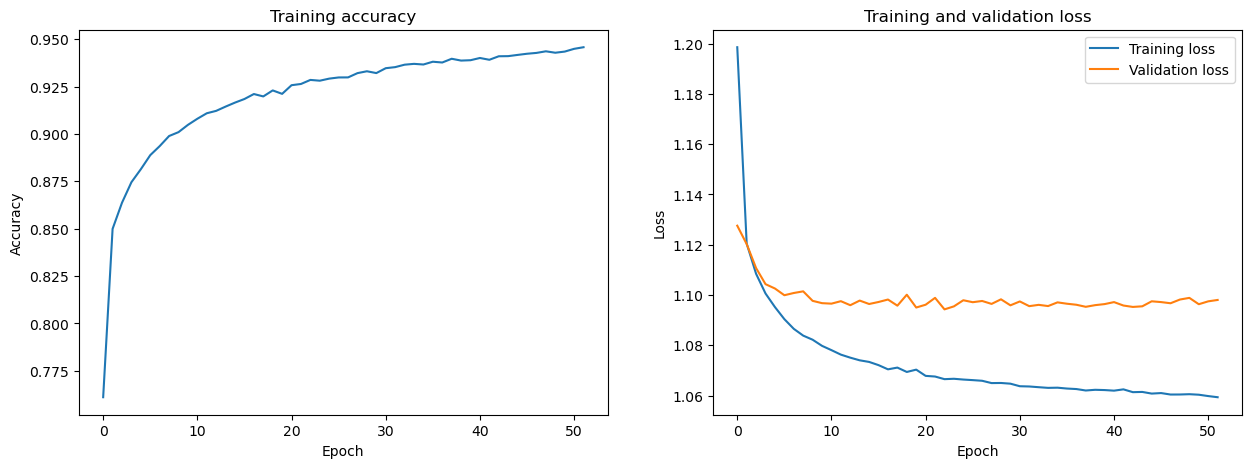

In [10]:
import pandas as pd
import matplotlib.pyplot as plt


# Load the metrics with pandas
train_accuracy = pd.read_csv('mlruns/0/e147157636f740e197ba27b27402209b/metrics/train_accuracy',sep=' ',header=None, names=["Time", "Accuracy", "Step"])
train_loss = pd.read_csv('mlruns/0/e147157636f740e197ba27b27402209b/metrics/train_loss',sep=' ', names=["Time", "Train_Loss", "Step"])
val_loss = pd.read_csv('mlruns/0/e147157636f740e197ba27b27402209b/metrics/val_loss',sep=' ', names=["Time", "Val_Loss", "Step"])

# Plot the metrics
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(train_accuracy['Step'], train_accuracy['Accuracy'])
ax[0].set_title('Training accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[1].plot(train_loss['Step'], train_loss['Train_Loss'], label='Training loss')
ax[1].plot(val_loss['Step'], val_loss['Val_Loss'], label='Validation loss')
ax[1].set_title('Training and validation loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
plt.show()


# Model validation

Prediction: [0.00000, 0.00000, 0.00000, 0.21735, 0.78265]
Label:      [0.00333, 0.12111, 0.00000, 0.00000, 0.87556]


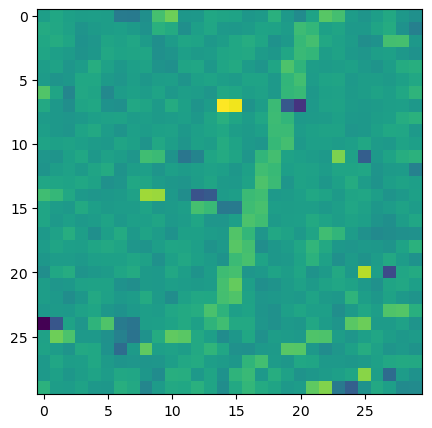

In [11]:
# Load the saved model
model_weights = torch.load('../models/state_estimator.pt')

# Create a new model instance
model = StateEstimator(model_opt='noise_opt')

# Load the model weights
model.load_state_dict(model_weights)

# Set the model to evaluation mode
model.eval()

# Get a random index
random_idx = np.random.randint(0, validation_data_transpose.shape[0])

# Get the prediction
prediction = model(torch.from_numpy(validation_data_transpose[random_idx, :, :, :]).unsqueeze(0).float())

# Convert the tensor to numpy array for easier formatting
pred_array = prediction.detach().numpy()[0]  # Take the first row since prediction is 2D

# Using f-string for nicer printing
pred_str = ", ".join([f"{val:.5f}" for val in pred_array])
label_str = ", ".join([f"{val:.5f}" for val in validation_labels[random_idx]])

print(f"Prediction: [{pred_str}]")
print(f"Label:      [{label_str}]")

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(validation_data[random_idx, :, :, 0])
plt.show()

In [24]:
from ml_tools.preprocessing.subimage_preprocessor import SubImagePreprocessor

# Get all the .npy files in the folder
data_files = glob.glob('../data/raw/data_qflow_v2/experimental/exp_small/dataset_0/*.npy')

print(data_files)

# extract only what we need from the data.
# note that there is no noise_class label for experimental data
exp_data = []; exp_labels = []
for f in data_files:
    d = np.load(f, allow_pickle=True).item()
    exp_data.append(d['sensor'])
    exp_labels.append(d['label'])

# convert only labels to list because exp_data contains different shaped data.
exp_labels = np.array(exp_labels)

# preprocess
# Autoflip because sensor gradient sign is unknown. 
# Don't denoise because it doesn't help.
exp_prepper = SubImagePreprocessor(
    auto_invert=True,
    noise_reduction=[],
    clip_value=None,
    cutoff_value= None
)

proc_exp_data,exp_labels = exp_prepper.preprocess_subimages(exp_data,exp_labels)

['../data/raw/data_qflow_v2/experimental/exp_small/dataset_0/d_0_file_081.npy', '../data/raw/data_qflow_v2/experimental/exp_small/dataset_0/d_0_file_080.npy', '../data/raw/data_qflow_v2/experimental/exp_small/dataset_0/d_0_file_079.npy', '../data/raw/data_qflow_v2/experimental/exp_small/dataset_0/d_0_file_078.npy', '../data/raw/data_qflow_v2/experimental/exp_small/dataset_0/d_0_file_077.npy', '../data/raw/data_qflow_v2/experimental/exp_small/dataset_0/d_0_file_076.npy', '../data/raw/data_qflow_v2/experimental/exp_small/dataset_0/d_0_file_075.npy', '../data/raw/data_qflow_v2/experimental/exp_small/dataset_0/d_0_file_074.npy', '../data/raw/data_qflow_v2/experimental/exp_small/dataset_0/d_0_file_073.npy', '../data/raw/data_qflow_v2/experimental/exp_small/dataset_0/d_0_file_072.npy', '../data/raw/data_qflow_v2/experimental/exp_small/dataset_0/d_0_file_071.npy', '../data/raw/data_qflow_v2/experimental/exp_small/dataset_0/d_0_file_070.npy', '../data/raw/data_qflow_v2/experimental/exp_small/d

In [27]:
import torch.nn.functional as F

# Transpose the data to match the model input
proc_exp_data_transpose = np.transpose(proc_exp_data, (0, 3, 1, 2))

def compute_loss_and_accuracy(model, data, labels):
    # Convert the data and labels to PyTorch tensors
    data_tensor = torch.from_numpy(data).float()
    labels_tensor = torch.argmax(torch.from_numpy(labels), dim=1).long()

    # Pass the data through the model
    predictions = model(data_tensor)
    
    # Compute the loss
    loss = F.cross_entropy(predictions, labels_tensor)
    
    # Compute the accuracy
    predicted_labels = torch.argmax(predictions, dim=1)
    accuracy = (predicted_labels == labels_tensor).float().mean().item()
    
    return loss.item(), accuracy

# Compute the loss and accuracy for the experimental data
exp_loss, exp_accuracy = compute_loss_and_accuracy(model, proc_exp_data_transpose, exp_labels)

print(f"Experimental Data Loss: {exp_loss:.4f}")
print(f"Experimental Data Accuracy: {exp_accuracy*100:.2f}%")


Experimental Data Loss: 1.0398
Experimental Data Accuracy: 87.80%
